# Exploratory Notebook

ALL group members

## 1. Business Problem and Understanding

**Stakeholders:**

[business problem and background]

**Preliminary Questions include:**

-
-
- 

Databases:

**The goal:**

In [163]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import sqlite3
import re
from datetime import datetime

%matplotlib inline


In [164]:
# Load in csv & tsv data

# tsv's are tabbular and take '\t' as the delimiter
# 'rt.reviews.tsv' did not take default uft-8 decoding

df_gross = pd.read_csv('Data/bom.movie_gross.csv')
df_info = pd.read_csv('Data/rt.movie_info.tsv', delimiter='\t')
df_rev = pd.read_csv('Data/rt.reviews.tsv', delimiter='\t', encoding='latin-1')
df_db = pd.read_csv('Data/tmdb.movies.csv', index_col=0)
df_budg = pd.read_csv('Data/tn.movie_budgets.csv')

In [67]:
# create sql connection to database
conn = sqlite3.connect('Data/im.db')
cur = conn.cursor()

In [68]:
# Join movie_basics and movie_ratings & create df

q = ''' SELECT *
FROM movie_basics
JOIN movie_ratings
USING (movie_id)
'''

df_basics = pd.read_sql(q, conn)

In [69]:
# Join persons with directors
q = ''' SELECT *
FROM persons
JOIN directors
USING (person_id)
'''

df_directors = pd.read_sql(q, conn)

In [70]:
# Join persons with writers
q = ''' SELECT *
FROM persons
JOIN writers
USING (person_id)
'''

df_writers = pd.read_sql(q, conn)

In [71]:
# Join persons with known_for
q = ''' SELECT *
FROM persons
JOIN known_for
USING (person_id)
'''

df_known_for = pd.read_sql(q, conn)

In [72]:
# Create df for movie_akas

q = '''
SELECT *
FROM movie_akas
'''
df_akas = pd.read_sql(q,conn)

In [73]:
# Create df for principals

q = '''
SELECT *
FROM principals
'''
df_principals = pd.read_sql(q,conn)

## 2. Data Structure Exploration

In [74]:
# Create function to get df summary
def df_summary(df):
    print(df.head(3))
    print(df.info())
    print(df.isna().sum())
    print(df.isna().sum()/len(df)*100)

#### `df_basics`

- Drop nas
- Lowercase object columns

In [11]:
df_summary(df_basics)

    movie_id                    primary_title              original_title  \
0  tt0063540                        Sunghursh                   Sunghursh   
1  tt0066787  One Day Before the Rainy Season             Ashad Ka Ek Din   
2  tt0069049       The Other Side of the Wind  The Other Side of the Wind   

   start_year  runtime_minutes              genres  averagerating  numvotes  
0        2013            175.0  Action,Crime,Drama            7.0        77  
1        2019            114.0     Biography,Drama            7.2        43  
2        2018            122.0               Drama            6.9      4517  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int

#### `df_akas`

- Can use to compare language to gross amount

In [12]:
df_summary(df_akas)

    movie_id  ordering                                    title region  \
0  tt0369610        10                            Джурасик свят     BG   
1  tt0369610        11                        Jurashikku warudo     JP   
2  tt0369610        12  Jurassic World: O Mundo dos Dinossauros     BR   

  language        types attributes  is_original_title  
0       bg         None       None                0.0  
1     None  imdbDisplay       None                0.0  
2     None  imdbDisplay       None                0.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331703 entries, 0 to 331702
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   movie_id           331703 non-null  object 
 1   ordering           331703 non-null  int64  
 2   title              331703 non-null  object 
 3   region             278410 non-null  object 
 4   language           41715 non-null   object 
 5   types              16

#### `df_directors`, `df_writers`, `df_known_for`

- Without gender and other socio cultural details, not sure this information can be used.

In [13]:
df_summary(df_directors)
print('___________________________________________________________________________')
df_summary(df_writers)
print('___________________________________________________________________________')
df_summary(df_known_for)

   person_id    primary_name  birth_year  death_year  \
0  nm0062879  Ruel S. Bayani         NaN         NaN   
1  nm0062879  Ruel S. Bayani         NaN         NaN   
2  nm0062879  Ruel S. Bayani         NaN         NaN   

                          primary_profession   movie_id  
0  director,production_manager,miscellaneous  tt1592569  
1  director,production_manager,miscellaneous  tt1592569  
2  director,production_manager,miscellaneous  tt1592569  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291171 entries, 0 to 291170
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   person_id           291171 non-null  object 
 1   primary_name        291171 non-null  object 
 2   birth_year          68608 non-null   float64
 3   death_year          1738 non-null    float64
 4   primary_profession  290187 non-null  object 
 5   movie_id            291171 non-null  object 
dtypes: float64(2), object(4)
mem

#### `df_principals`

- Not sure if we will use this table
- If we do, we may be able to fill in from other tables

In [14]:
df_summary(df_principals)

    movie_id  ordering  person_id  category       job   characters
0  tt0111414         1  nm0246005     actor      None  ["The Man"]
1  tt0111414         2  nm0398271  director      None         None
2  tt0111414         3  nm3739909  producer  producer         None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028186 entries, 0 to 1028185
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   movie_id    1028186 non-null  object
 1   ordering    1028186 non-null  int64 
 2   person_id   1028186 non-null  object
 3   category    1028186 non-null  object
 4   job         177684 non-null   object
 5   characters  393360 non-null   object
dtypes: int64(1), object(5)
memory usage: 47.1+ MB
None
movie_id           0
ordering           0
person_id          0
category           0
job           850502
characters    634826
dtype: int64
movie_id       0.000000
ordering       0.000000
person_id      0.000000
category       0.

#### `df_gross`

- `df_budg` has more complete info on gross numbers. May not use.

In [157]:
df_summary(df_gross)

                                         title studio  domestic_gross  \
0                                  Toy Story 3     BV     415000000.0   
1                   Alice in Wonderland (2010)     BV     334200000.0   
2  Harry Potter and the Deathly Hallows Part 1     WB     296000000.0   

  foreign_gross  year  
0     652000000  2010  
1     691300000  2010  
2     664300000  2010  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB
None
title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype:

#### `df_info`

- Too many missing values. May not use.

In [79]:
df_summary(df_info)

   id                                           synopsis rating  \
0   1  This gritty, fast-paced, and innovative police...      R   
1   3  New York City, not-too-distant-future: Eric Pa...      R   
2   5  Illeana Douglas delivers a superb performance ...      R   

                                 genre          director  \
0  Action and Adventure|Classics|Drama  William Friedkin   
1    Drama|Science Fiction and Fantasy  David Cronenberg   
2    Drama|Musical and Performing Arts    Allison Anders   

                         writer  theater_date      dvd_date currency  \
0                Ernest Tidyman   Oct 9, 1971  Sep 25, 2001      NaN   
1  David Cronenberg|Don DeLillo  Aug 17, 2012   Jan 1, 2013        $   
2                Allison Anders  Sep 13, 1996  Apr 18, 2000      NaN   

  box_office      runtime             studio  
0        NaN  104 minutes                NaN  
1    600,000  108 minutes  Entertainment One  
2        NaN  116 minutes                NaN  
<class 'panda

#### `df_rev`

- Not sure if there is enough significant information.

In [17]:
df_summary(df_rev)

   id                                             review rating   fresh  \
0   3  A distinctly gallows take on contemporary fina...    3/5   fresh   
1   3  It's an allegory in search of a meaning that n...    NaN  rotten   
2   3  ... life lived in a bubble in financial dealin...    NaN   fresh   

           critic  top_critic         publisher               date  
0      PJ Nabarro           0   Patrick Nabarro  November 10, 2018  
1  Annalee Newitz           0           io9.com       May 23, 2018  
2    Sean Axmaker           0  Stream on Demand    January 4, 2018  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  in

#### `df_db`

- No nulls
- Create new column `release_year` from `release_date`

In [14]:
df_summary(df_db)

             genre_ids     id original_language  \
0      [12, 14, 10751]  12444                en   
1  [14, 12, 16, 10751]  10191                en   
2        [12, 28, 878]  10138                en   

                                 original_title  popularity release_date  \
0  Harry Potter and the Deathly Hallows: Part 1      33.533   2010-11-19   
1                      How to Train Your Dragon      28.734   2010-03-26   
2                                    Iron Man 2      28.515   2010-05-07   

                                          title  vote_average  vote_count  
0  Harry Potter and the Deathly Hallows: Part 1           7.7       10788  
1                      How to Train Your Dragon           7.7        7610  
2                                    Iron Man 2           6.8       12368  
<class 'pandas.core.frame.DataFrame'>
Index: 26517 entries, 0 to 26516
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             -----------

#### `df_budg`

- No nulls
- 'movie' = 'title'
- Adjust 'release_date' if using for analysis
- Adjust 'gross' columns to int

In [15]:
df_summary(df_budg)

   id  release_date                                        movie  \
0   1  Dec 18, 2009                                       Avatar   
1   2  May 20, 2011  Pirates of the Caribbean: On Stranger Tides   
2   3   Jun 7, 2019                                 Dark Phoenix   

  production_budget domestic_gross worldwide_gross  
0      $425,000,000   $760,507,625  $2,776,345,279  
1      $410,600,000   $241,063,875  $1,045,663,875  
2      $350,000,000    $42,762,350    $149,762,350  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memor

## 3. Data Cleaning & Preprocessing

In [75]:
# Lowercase function
def lowercase(df):
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].str.lower()
    return df

#### Cleaning df_basics

In [78]:
# Make cleaning copy
df_basics_c = df_basics.copy()

# Address lowercase
lowercase(df_basics_c)

# Replace 0s & blank spaces with nas
df_basics_c.replace(0,np.nan,inplace=True)
df_basics_c = df_basics_c.map(lambda x: np.nan if isinstance(x, str) and x.strip() == "" else x)
print("nan check:\n", df_basics_c.isna().sum()/len(df_basics_c)*100)

# Drop remaining nans
df_basics_c.dropna(inplace=True)
print("\nShape after cleaning:",df_basics_c.shape)

# Create primary_genre column
df_basics_c['primary_genre'] = df_basics_c.genres.apply(lambda x: x.split(',')[0])

df_basics_c.head()

nan check:
 movie_id            0.000000
primary_title       0.000000
original_title      0.000000
start_year          0.000000
runtime_minutes    10.317374
genres              1.088605
averagerating       0.000000
numvotes            0.000000
dtype: float64

Shape after cleaning: (65720, 8)


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,primary_genre
0,tt0063540,sunghursh,sunghursh,2013,175.0,"action,crime,drama",7.0,77,action
1,tt0066787,one day before the rainy season,ashad ka ek din,2019,114.0,"biography,drama",7.2,43,biography
2,tt0069049,the other side of the wind,the other side of the wind,2018,122.0,drama,6.9,4517,drama
4,tt0100275,the wandering soap opera,la telenovela errante,2017,80.0,"comedy,drama,fantasy",6.5,119,comedy
6,tt0137204,joe finds grace,joe finds grace,2017,83.0,"adventure,animation,comedy",8.1,263,adventure


It looks like this dataset is missing 10 years of information from the timeline we are looking at based on the release year in other databases which maxes out at 2020 and the information found about the newest era being post millenium.

**Source:** <a href = "http://www.historyoffilm.net/movie-eras/history-of-cinema/#:~:text=With%20over%20100%20years%20of,every%20decade%20of%20its%20history.">Movie Eras - History of Cinema and the First Film</a>

In [59]:
print("release_year range:", df_basics_c.start_year.min(), df_basics_c.start_year.max())

# Filter out years before 2000
df_basics_c = df_basics_c[df_basics_c['start_year']>1999]
print(df_basics_c.shape)

release_year range: 2010 2019
(65720, 9)


#### Cleaning df_db

While cleaning, certain 0s unmarked as nans were uncovered in the `average_votes` column. The number is small so we can drop these numbers. If we want to use in analysis for average votes for each `primary_genre` we can potentially distribute based on relative probability. Decided to check for object missingness not registering as nans and found ~9% of `genre_ids` missing as well.

To match `genre_ids` with their respective genre name, we used <a href = "https://www.themoviedb.org/talk/5daf6eb0ae36680011d7e6ee">The Movie Databse</a> as reference.

In [151]:
# Create a cleaning copy
df_db_c = df_db.copy()

# Address lowercase
lowercase(df_db_c).head(10)
    
# create release_year column and convert to int
df_db_c['release_year'] = df_db_c['release_date'].apply(lambda x: int(x.split('-')[0]))

# strip genre_ids of []
df_db_c['genre_ids'] = df_db_c['genre_ids'].apply(lambda x: x.strip('[]').strip(""))

# extract primary genre_id & create a new column 'primary_genre'
df_db_c['primary_genre'] = df_db_c['genre_ids'].apply(lambda x: x.split(',')[0])


data_text = '''
Action          28
Adventure       12
Animation       16
Comedy          35
Crime           80
Documentary     99
Drama           18
Family          10751
Fantasy         14
History         36
Horror          27
Music           10402
Mystery         9648
Romance         10749
Science Fiction 878
TV Movie        10770
Thriller        53
War             10752
Western         37
'''

# Convert the text into a list of tuples
genre_list = [tuple(line.split(maxsplit=1)) for line in data_text.strip().split('\n')]

# Convert the list of into a dictionary
genre_dict = dict(genre_list)

# Iterate over each genre_ids to replace with genre name bsed on genre_dict
for k, v in genre_dict.items():
    df_db_c.loc[df_db_c['primary_genre'].str.contains(v), 'primary_genre'] = k.lower()

# Replace 0s & blank spaces with nas
df_db_c.replace(0,np.nan,inplace=True)
df_db_c = df_db_c.map(lambda x: np.nan if isinstance(x, str) and x.strip() == "" else x)
print('nan check:\n',df_db_c.isna().sum()/len(df_budg_c)*100)

# Drop remaining nans
df_db_c.dropna(inplace=True)

print("\nShape after cleaning:",df_db_c.shape)
df_db_c.head()

nan check:
 genre_ids            62.255148
id                    0.000000
original_language     0.000000
original_title        0.000000
popularity            0.000000
release_date          0.000000
title                 0.000000
vote_average          3.415369
vote_count            0.000000
release_year          0.000000
primary_genre        62.255148
dtype: float64

Shape after cleaning: (23922, 11)


,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,release_year,primary_genre
0,"12, 14, 10751",12444,en,harry potter and the deathly hallows: part 1,33.533,2010-11-19,harry potter and the deathly hallows: part 1,7.7,10788,2010,adventure
1,"14, 12, 16, 10751",10191,en,how to train your dragon,28.734,2010-03-26,how to train your dragon,7.7,7610,2010,fantasy
2,"12, 28, 878",10138,en,iron man 2,28.515,2010-05-07,iron man 2,6.8,12368,2010,adventure
3,"16, 35, 10751",862,en,toy story,28.005,1995-11-22,toy story,7.9,10174,1995,animation
4,"28, 878, 12",27205,en,inception,27.920,2010-07-16,inception,8.3,22186,2010,action


In [56]:
print("release_year range:", df_db_c.release_year.min(), df_db_c.release_year.max())

# Filter out years before 2000
df_db_c = df_db_c[df_db_c['release_year']>1999]
print(df_db_c.shape)

release_year range: 2000 2020
(26398, 11)


It looks like `vote_average` is out of 10 so can be considered a 'rating' potentially. It's possible `popularity` is out of 100, though the max is 80.773. The max year is 2020, which may limit other databases we use if we want all years to align

In [163]:
# Explore columns

print("vote_average range:", df_db.vote_average.values.min(), df_db.vote_average.values.max())
print("popularity range:", df_db.popularity.values.min(), df_db.popularity.values.max())
print("release_year range:", df_db.release_year.min(), df_db.release_year.max())
print("top_10_languages:", df_db.original_language.value_counts().head(10))

vote_average range: 0.0 10.0
popularity range: 0.6 80.773
release_year range: 1930 2020
top_10_languages: original_language
en    23291
fr      507
es      455
ru      298
ja      265
de      237
zh      177
hi      172
it      123
pt       96
Name: count, dtype: int64


#### Cleaning df_budg

In [171]:
# Create cleaning copy
df_budg_c = df_budg.copy()

# Address lowercase 
lowercase(df_budg_c).head(10)

# Adjust release_date structure
df_budg_c.release_date = pd.to_datetime(df_budg_c.release_date,format='%b %d, %Y')
df_budg_c.release_date = df_budg_c.release_date.dt.strftime('%Y-%m-%d')

# Create release_year as an int
df_budg_c['release_year'] = df_budg_c['release_date'].apply(lambda x: int(x.split('-')[0]))


# Convert dollar columns to int
df_budg_c['production_budget'] = df_budg_c['production_budget'].str.replace(',', '').str.replace('$', '').astype(int)
df_budg_c['domestic_gross'] = df_budg_c['domestic_gross'].str.replace(',', '').str.replace('$', '').astype(int)
df_budg_c['worldwide_gross'] = df_budg_c['worldwide_gross'].str.replace(',', '').str.replace('$', '').astype(int)

# Create foreign_gross column
df_budg_c['foreign_gross'] = df_budg_c.worldwide_gross - df_budg_c.domestic_gross

# Replace 0s & blank spaces with nas
df_budg_c.replace(0,np.nan,inplace=True)
df_budg_c = df_budg_c.map(lambda x: np.nan if isinstance(x, str) and x.strip() == "" else x)
print('nan check:\n',df_budg_c.isna().sum()/len(df_budg_c)*100)

# Drop remaining nans
df_budg_c.dropna(inplace=True)

print("\nShape after cleaning:",df_budg_c.shape)
df_budg_c.head()
df_budg_c.worldwide_gross.min()

nan check:
 id                    0.000000
release_date          0.000000
movie                 0.000000
production_budget     0.000000
domestic_gross        9.477689
worldwide_gross       6.347285
release_year          0.000000
foreign_gross        28.000692
dtype: float64

Shape after cleaning: (3982, 8)


10679.0

Adjust the year in the dataset based on estabilished range.

In [85]:
print("release_year range:", df_budg_c.release_year.min(), df_budg_c.release_year.max())

# Filter out years before 2000
df_budg_c = df_budg_c[df_budg_c['release_year']>1999]
print(df_budg_c.shape)

release_year range: 1915 2019
(3366, 8)


### Data Merging

We want to merge `df_budg_c` and `df_db` to compare grossing information with `popularity`, `vote_average`, and `primary_genre`. Since `df_budg_c` is so much smaller, it will serve as the base for this analysis to avoid having to drop nan rows. 

We will attempt to merge on `movie` and `title`, so first, we will adjust the names of those columns for ease then create a unique identifier column combining `movie_title` and `release_date`. Then we can clean up the data and delete any duplicate values.

**Note:** After deleting duplicates, there are still 4 records with the same `unique_movie` identifier column in `df_db_c` we created. Since it is a small portion of the data, we drop those as well.

In [173]:
# Rename columns in each df
df_db_c.rename(columns={"title":"movie_title"},inplace=True)
df_budg_c.rename(columns={"movie":"movie_title"},inplace=True)

# Create unique identifier column in both dbs with movie_title + release_year to try to eliminate duplicate movie_titles
df_db_c['unique_movie'] = df_db_c[['movie_title','release_date']].apply(lambda x: ''.join(x.astype(str)),axis=1)
df_budg_c['unique_movie'] = df_budg_c[['movie_title','release_date']].apply(lambda x: ''.join(x.astype(str)),axis=1)

# Get rid of all characters in unique identifier column
df_db_c['unique_movie'] = df_db_c['unique_movie'].apply(lambda x: re.sub(r'[^\w\s]|_|\s', '', x))
df_budg_c['unique_movie'] = df_budg_c['unique_movie'].apply(lambda x: re.sub(r'[^\w\s]|_|\s', '', x))

# Get rid of duplicates
df_db_c.drop_duplicates(inplace=True,subset='unique_movie')
df_budg_c.drop_duplicates(inplace=True,subset='unique_movie')

df_db_c.unique_movie.value_counts()
df_budg_c.unique_movie.value_counts()

# Check shape of each dataset
print(df_budg_c.shape)
print(df_db_c.shape)

(3982, 9)
(22922, 12)


Now that the unique column has been created in both databases and duplicates have been takec care of, we are ready to merge the two databases `df_db_c` and `df_budg_c`. Once merged, we can drop unnecessary columns for the analysis.

In [150]:
db_budg = pd.merge(df_budg_c,df_db_c,on='unique_movie')
db_budg.drop(['release_year_y','movie_title_y','release_date_y','id_y','id_x','genre_ids','original_title'],inplace=True,axis=1)
db_budg

,release_date_x,movie_title_x,production_budget,domestic_gross,worldwide_gross,release_year_x,foreign_gross,unique_movie,original_language,popularity,vote_average,vote_count,primary_genre
0,2009-12-18,avatar,425000000,760507625.0,2.776345e+09,2009,2.015838e+09,avatar20091218,en,26.526,7.4,18676,action
1,2011-05-20,pirates of the caribbean: on stranger tides,410600000,241063875.0,1.045664e+09,2011,8.046000e+08,piratesofthecaribbeanonstrangertides20110520,en,30.579,6.4,8571,adventure
2,2015-05-01,avengers: age of ultron,330600000,459005868.0,1.403014e+09,2015,9.440081e+08,avengersageofultron20150501,en,44.383,7.3,13457,action
3,2018-04-27,avengers: infinity war,300000000,678815482.0,2.048134e+09,2018,1.369319e+09,avengersinfinitywar20180427,en,80.773,8.3,13948,adventure
4,2017-11-17,justice league,300000000,229024295.0,6.559452e+08,2017,4.269209e+08,justiceleague20171117,en,34.953,6.2,7510,action
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178,2015-06-19,the overnight,200000,1109808.0,1.165996e+06,2015,5.618800e+04,theovernight20150619,en,6.576,6.0,200,mystery
1179,2011-07-22,another earth,175000,1321194.0,2.102779e+06,2011,7.815850e+05,anotherearth20110722,en,10.030,6.7,853,drama
1180,2015-07-10,the gallows,100000,22764410.0,4.165647e+07,2015,1.889206e+07,thegallows20150710,en,9.166,4.8,591,horror
1181,2017-07-07,a ghost story,100000,1594798.0,2.769782e+06,2017,1.174984e+06,aghoststory20170707,en,11.886,7.0,906,drama


## 4. Data Exploration and Analysis

First, we want to look at the highest grossing movies domestic, foreign, and worldwide.

In [152]:
db_budg.head()

,release_date_x,movie_title_x,production_budget,domestic_gross,worldwide_gross,release_year_x,foreign_gross,unique_movie,original_language,popularity,vote_average,vote_count,primary_genre
0,2009-12-18,avatar,425000000,760507625.0,2.776345e+09,2009,2.015838e+09,avatar20091218,en,26.526,7.4,18676,action
1,2011-05-20,pirates of the caribbean: on stranger tides,410600000,241063875.0,1.045664e+09,2011,8.046000e+08,piratesofthecaribbeanonstrangertides20110520,en,30.579,6.4,8571,adventure
2,2015-05-01,avengers: age of ultron,330600000,459005868.0,1.403014e+09,2015,9.440081e+08,avengersageofultron20150501,en,44.383,7.3,13457,action
3,2018-04-27,avengers: infinity war,300000000,678815482.0,2.048134e+09,2018,1.369319e+09,avengersinfinitywar20180427,en,80.773,8.3,13948,adventure
4,2017-11-17,justice league,300000000,229024295.0,6.559452e+08,2017,4.269209e+08,justiceleague20171117,en,34.953,6.2,7510,action


worldwide_gross                                               \
primary_genre             878        action     adventure animation comedy   
0                         NaN  2.776345e+09           NaN       NaN    NaN   
1                         NaN           NaN  1.045664e+09       NaN    NaN   
2                         NaN  1.403014e+09           NaN       NaN    NaN   
3                         NaN           NaN  2.048134e+09       NaN    NaN   
4                         NaN  6.559452e+08           NaN       NaN    NaN   
...                       ...           ...           ...       ...    ...   
1178                      NaN           NaN           NaN       NaN    NaN   
1179                      NaN           NaN           NaN       NaN    NaN   
1180                      NaN           NaN           NaN       NaN    NaN   
1181                      NaN           NaN           NaN       NaN    NaN   
1182                      NaN           NaN           NaN       NaN    NaN   

                                                           ... foreign_gross  \
primary_genre crime documentary      drama family fantasy  ...        family   
0               NaN         NaN        NaN    NaN     NaN  ...           NaN   
1               NaN         NaN        NaN    NaN     NaN  ...           NaN   
2               NaN         NaN        NaN    NaN     NaN  ...           NaN   
3               NaN         NaN        NaN    NaN     NaN  ...           NaN   
4               NaN         NaN        NaN    NaN     NaN  ...           NaN   
...             ...         ...        ...    ...     ...  ...           ...   
1178            NaN         NaN        NaN    NaN     NaN  ...           NaN   
1179            NaN         NaN  2102779.0    NaN     NaN  ...           NaN   
1180            NaN         NaN        NaN    NaN     NaN  ...           NaN   
1181            NaN         NaN  2769782.0    NaN     NaN  ...           NaN   
1182            NaN         NaN        NaN    NaN     NaN  ...           NaN   

                                                                            \
primary_genre fantasy history      horror music  mystery  romance thriller   
0                 NaN     NaN         NaN   NaN      NaN      NaN      NaN   
1                 NaN     NaN         NaN   NaN      NaN      NaN      NaN   
2                 NaN     NaN         NaN   NaN      NaN      NaN      NaN   
3                 NaN     NaN         NaN   NaN      NaN      NaN      NaN   
4                 NaN     NaN         NaN   NaN      NaN      NaN      NaN   
...               ...     ...         ...   ...      ...      ...      ...   
1178              NaN     NaN         NaN   NaN  56188.0      NaN      NaN   
1179              NaN     NaN         NaN   NaN      NaN      NaN      NaN   
1180              NaN     NaN  18892064.0   NaN      NaN      NaN      NaN   
1181              NaN     NaN         NaN   NaN      NaN      NaN      NaN   
1182              NaN     NaN         NaN   NaN      NaN  32475.0      NaN   

                           
primary_genre war western  
0             NaN     NaN  
1             NaN     NaN  
2             NaN     NaN  
3             NaN     NaN  
4             NaN     NaN  
...            ..     ...  
1178          NaN     NaN  
1179          NaN     NaN  
1180          NaN     NaN  
1181          NaN     NaN  
1182          NaN     NaN  

[1183 rows x 54 columns]

<Axes: xlabel='worldwide_gross', ylabel='Density'>

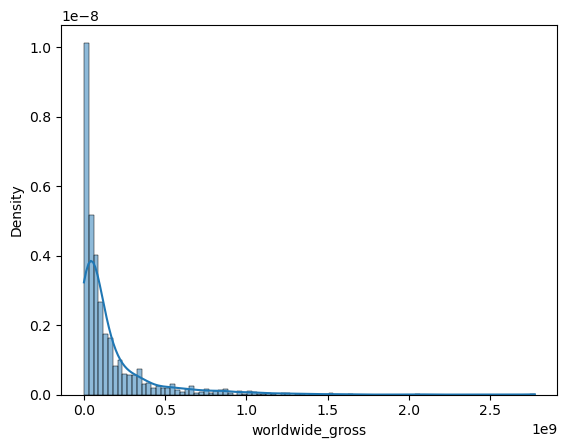

In [162]:
db_budg_flt = db_budg.loc[[db_bu]

sns.histplot(db_budg.worldwide_gross,kde=True,stat='density')